<a href="https://colab.research.google.com/github/AdrianGuel/PhDThesis/blob/main/ch4/Kramersequation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install KDEpy
!pip install torchsde

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [15]:
from typing import Sequence
import torchsde
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import torch
import tqdm
from torch import nn
from torch import optim
from torch.distributions import Normal

class Kramers(object):
    """Stochastic kramers equation
    """
    noise_type = "diagonal"
    sde_type = "ito"

    def __init__(self, a: Sequence = (0., 1., -2.,-3.), b: Sequence = (.1, .1)):
        super(Kramers, self).__init__()
        self.a = a
        self.b = b

    def f(self, t, y):
        x1, x2 = torch.split(y, split_size_or_sections=(1, 1), dim=1)
        a11, a12, a21, a22 = self.a

        f1 = a11 *x1+a12*x2
        #f2 = a21*torch.sin(x1)+a22*x2
        f2 = a21*x1+a22*x2
        return torch.cat([f1, f2], dim=1)

    def g(self, t, y):
        x1, x2= torch.split(y, split_size_or_sections=(1, 1), dim=1)
        b1, b2= self.b

        g1 = b1+0*x1#x1 * b1
        g2 = b2+0*x2#x2 * b2
        return torch.cat([g1, g2], dim=1)

    @torch.no_grad()
    def sample(self, x0, ts):
        """Sample data for training. Store data normalization constants if necessary."""
        xs = torchsde.sdeint(self, x0, ts, method='srk',adaptive=True)
        return xs

In [16]:
#Theoretical results
from scipy.integrate import odeint
import numpy as np

def Mu(y, t, g,w):
    return np.array([y[1], -(w)*y[0] -g*y[1]])

def Sigma(y, t, g, w, b1,b2):
    return np.array([b1**2+2*y[1],b1*b2-g*y[1]+y[2]-y[0]*w,b2**2-2*g*y[2]-2*y[1]*w])

t_size,tf= 10**2,6
t = np.linspace(0, tf, t_size)
m0,s0=np.array([1,0.5]),np.array([0.1,0,0.1])
b1,b2=0.1,0.1
g,w=3.,2.
M = odeint(Mu, m0, t, args=(g, w))
S = odeint(Sigma, s0, t, args=(g, w,b1,b2))

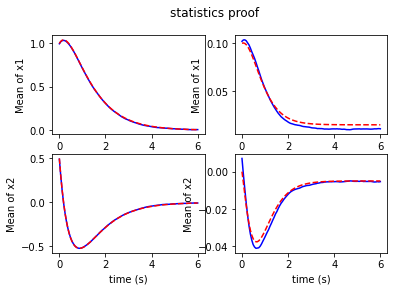

In [17]:
batch_size, state_size = 10**3, 2
gpu = torch.device('cuda')
mu0,Sigma0=torch.tensor([1,0.5]),0.1*torch.eye(2)
y0=torch.distributions.multivariate_normal.MultivariateNormal(mu0, Sigma0).sample(sample_shape=torch.Size([batch_size]))
y0=y0.to(gpu)
ts = torch.linspace(0, tf, t_size, device='cuda')
xs = Kramers().sample(y0, ts)
x1=xs[:,:,0].cpu().detach().numpy()
x2=xs[:,:,1].cpu().detach().numpy()
Mx1,Mx2=np.zeros(t_size),np.zeros(t_size)
vx12=np.zeros((4,t_size))

for i in range(0,t_size):
  Mx1[i]=np.mean(x1[i,:])
  Mx2[i]=np.mean(x2[i,:])
  vx12[:,i]=np.cov(x1[i,:],x2[i,:],bias=True).flatten('F')

fig, axs = plt.subplots(2, 2)
fig.suptitle('statistics proof')

axs[0,0].plot(t,Mx1,'b')
axs[0,0].plot(t,M[:,0],'r--')
axs[0,0].set_ylabel('Mean of x1')

axs[1,0].plot(t,Mx2,'b')
axs[1,0].plot(t,M[:,1],'r--')
axs[1,0].set_xlabel('time (s)')
axs[1,0].set_ylabel('Mean of x2')

axs[0,1].plot(t,vx12[0,:],'b')
axs[0,1].plot(t,S[:,0],'r--')
axs[0,1].set_ylabel('Mean of x1')

axs[1,1].plot(t,vx12[1,:],'b')
axs[1,1].plot(t,S[:,1],'r--')
axs[1,1].set_xlabel('time (s)')
axs[1,1].set_ylabel('Mean of x2')
plt.show()

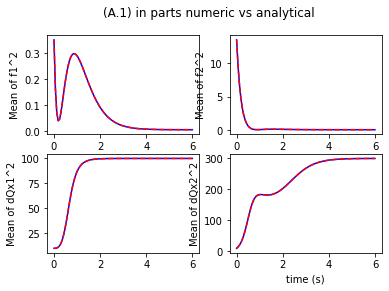

In [19]:
#checking AppendixA
#(A.1)
from scipy import integrate

def MGauss(x1,x2,M1,M2,s11,s12,s22):
  return (1/(2*np.sqrt((np.pi**2)*(-s12**2+s11*s22))))*np.exp((s11*M2**2+s22*(M1-x1)**2+2*s12*(M1-x1)*x2+s11*x2**2-2*M2*(M1*s12-s12*x1+s11*x2))/(2*(s12**2-s11*s22)))

def Mf1_2(S,M):
  return S[:,2]+M[:,1]**2

def Mf2_2(S,M):
  return (g**2*S[:,2]+2*g*S[:,1]*w+S[:,0]*w**2)+(M[:,1]*(g**2*M[:,1]+g*M[:,0]*w)+M[:,0]*(g*M[:,1]*w+M[:,0]*w**2))

def Mdqx1(S):
  return S[:,2]/(-S[:,1]**2+S[:,0]*S[:,2])

def Mdqx2(S):
  return S[:,0]/(-S[:,1]**2 + S[:,0]*S[:,2])

def f1_2(r1,r2,M1,M2,s11,s12,s22):
    return  ((0*r1+r2)**2)*MGauss(r1,r2,M1,M2,s11,s12,s22)

def f2_2(r1,r2,M1,M2,s11,s12,s22):
    return  ((-(w)*r1 -g*r2)**2)*MGauss(r1,r2,M1,M2,s11,s12,s22)

def dQx1(r1,r2,M1,M2,s11,s12,s22):
    return (((M2*s12-M1*s22+s22*r1-s12*r2)/(s12**2-s11*s22))**2)*MGauss(r1,r2,M1,M2,s11,s12,s22)

def dQx2(r1,r2,M1,M2,s11,s12,s22):
    return (((-M2*s11+M1*s12-s12*r1+s11*r2)/(s12**2-s11*s22))**2)*MGauss(r1,r2,M1,M2,s11,s12,s22)

Mf1,Mf2=np.zeros(t_size),np.zeros(t_size)
MdQx1,MdQx2=np.zeros(t_size),np.zeros(t_size)

for i in range(0,t_size):
  M1,M2=M[i,0], M[i,1]
  s11,s12,s22=S[i,0],S[i,1],S[i,2]
  Mf1[i]=integrate.nquad(f1_2,[[-5,5],[-5,5]],args=(M1,M2,s11,s12,s22))[0]
  Mf2[i]=integrate.nquad(f2_2,[[-5,5],[-5,5]],args=(M1,M2,s11,s12,s22))[0]
  MdQx1[i]=integrate.nquad(dQx1,[[-5,5],[-5,5]],args=(M1,M2,s11,s12,s22))[0]
  MdQx2[i]=integrate.nquad(dQx2,[[-5,5],[-5,5]],args=(M1,M2,s11,s12,s22))[0]

fig, axs = plt.subplots(2, 2)
fig.suptitle('(A.1) in parts numeric vs analytical')

axs[0,0].plot(t,Mf1,'b')
axs[0,0].plot(t,Mf1_2(S,M),'r--')
axs[0,0].set_ylabel('Mean of f1^2')

axs[0,1].plot(t,Mf2,'b')
axs[0,1].plot(t,Mf2_2(S,M),'r--')
axs[0,1].set_xlabel('time (s)')
axs[0,1].set_ylabel('Mean of f2^2')

axs[1,0].plot(t,MdQx1,'b')
axs[1,0].plot(t,Mdqx1(S),'r--')
axs[1,0].set_ylabel('Mean of dQx1^2')

axs[1,1].plot(t,MdQx2,'b')
axs[1,1].plot(t,Mdqx2(S),'r--')
axs[1,1].set_xlabel('time (s)')
axs[1,1].set_ylabel('Mean of dQx2^2')
plt.show()

In [7]:
import numpy as np
def distFunc(x,y):
    f = np.exp(-x+y)
    return f

# Values in x to evaluate the integral.
x = np.linspace(.1, 10, 100)
y = np.linspace(.1, 10, 100)
X, Y = np.meshgrid(x, y)

list1=distFunc(X, Y)
int_exp = np.trapz(np.trapz(list1, y, axis=0), x, axis=0)
int_exp2d = integrate.simpson(integrate.simpson(list1, y, axis=0), x, axis=0)
print(int_exp2d,int_exp)

19929.97185067699 19961.5927394128


In [38]:
with torch.no_grad():
    torch.cuda.empty_cache()

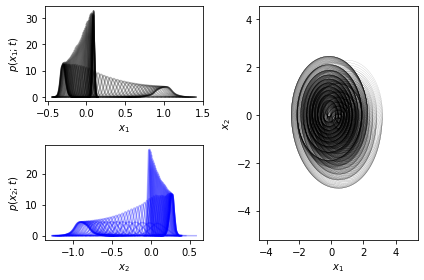

In [ ]:
from KDEpy import FFTKDE
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import matplotlib.gridspec as gridspec

# Create 2x2 sub plots
gs = gridspec.GridSpec(2, 2)
pl.figure()
pl.title('Kernel density estimation')
ax1 = pl.subplot(gs[0, 0])
ax1.set_xlabel('$x_1$') 
ax1.set_ylabel('$p(x_1;t)$') 
ax2 = pl.subplot(gs[1, 0]) 
ax2.set_xlabel('$x_2$') 
ax2.set_ylabel('$p(x_2;t)$') 
ax3 = pl.subplot(gs[:, 1])
ax3.set_xlabel('$x_1$') 
ax3.set_ylabel('$x_2$')  

grid_points = 10**2  # Grid points in each dimension
N = 10  # Number of contours

for i in range(0,t_size,10):
  data=np.array([x1[i,:].cpu().detach().numpy(),x2[i,:].cpu().detach().numpy()])
  kde = FFTKDE(kernel='gaussian', norm=2)
  grid, points = kde.fit(data.T).evaluate(grid_points)
  d_x1,px1 = FFTKDE(kernel='gaussian', bw='silverman').fit(x1[i,:].cpu().detach().numpy()).evaluate(grid_points)
  d_x2,px2 = FFTKDE(kernel='gaussian', bw='silverman').fit(x2[i,:].cpu().detach().numpy()).evaluate(grid_points)
  # The grid is of shape (obs, dims), points are of shape (obs, 1)
  x, y = np.unique(grid[:, 0]), np.unique(grid[:, 1])
  z = points.reshape(grid_points, grid_points).T
  # Plot the kernel density estimate
  ax1.plot(d_x1,px1, color='k', alpha=0.3)
  ax2.plot(d_x2,px2, color='b', alpha=0.3)
  ax3.contour(x, y, z, N, linewidths=0.1, colors='k', alpha=0.7)
  #ax.contourf(x, y, z, N, cmap="RdBu_r")
  #ax.plot(data[0, :], data[1, :], 'ok', ms=3)
plt.tight_layout()

In [ ]:
x = [-2.1, -1,  4.3]
y = [3,  1.1,  0.12]
X = np.stack((x, y), axis=0)
np.cov(X)

array([[11.71      , -4.286     ],
       [-4.286     ,  2.14413333]])

In [ ]:
axu=np.cov(x,y)

In [ ]:
axu[0,0]

11.709999999999999